# Disclaimer

The top 1000 dataset sourced from the Chrome UX report (CrUX) may contain adult content websites or websites that are not deemed trustworthy. Therefore, it is possible that these links may also appear in the requests dataset in this analysis. 

Links contained in the body text / markdown text were last checked on 27.06.2024.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import ast

# Reading the collected data

In [2]:
# Read the .csv file containing the request data
df = pd.read_csv('requests_10_08_2024.csv')

# Show 10 random entries
df.sample(10)

,Page,Full URL,Subdomain,Domain,Suffix,IP,CNAME,ASN,ASN Description,Response Headers
40022,https://www.sport24.gr,https://www.sport24.gr/img/9185/10361718/22300...,www,sport24,gr,104.18.4.126,NaN,13335.0,CLOUDFLARENET,"{'accept-ranges': 'bytes', 'age': '84143', 'ca..."
42480,https://articulo.mercadolibre.com.mx,https://http2.mlstatic.com/frontend-assets/hom...,http2,mlstatic,com,NaN,a2032.b.akamai.net,NaN,NaN,"{'access-control-allow-origin': '*', 'alt-svc'..."
38227,https://www.gov.br,https://www.gov.br/++resource++brasil.gov.tile...,NaN,www,gov.br,161.148.164.31,NaN,10954.0,SERVICO FEDERAL DE PROCESSAMENTO DE DADOS - SE...,"{'Accept-Ranges': 'bytes', 'Age': '0', 'Connec..."
7885,https://www.ndtv.com,https://am-trc-events.taboola.com/ndtv/log/2/d...,am-trc-events,taboola,com,151.101.194.132,am-vip001.taboola.com,54113.0,FASTLY,"{'access-control-allow-credentials': 'true', '..."
55847,https://www.temu.com,https://eu.pftk.temu.com/pmm/api/pmm/api,eu.pftk,temu,com,20.15.0.25,pftk-eu.temu.com,8075.0,MICROSOFT-CORP-MSN-AS-BLOCK,"{'access-control-allow-credentials': 'true', '..."
57510,https://www.disneyplus.com,https://disney.api.edge.bamgrid.com/graph/v1/d...,disney.api.edge,bamgrid,com,NaN,d16tf39cmx7ftb.cloudfront.net,NaN,NaN,"{'access-control-allow-credentials': 'true', '..."
12212,https://gendai.media,https://gendai-m.ismcdn.jp/mwimgs/2/3/360m/img...,gendai-m,ismcdn,jp,NaN,a1820.d.akamai.net,NaN,NaN,"{'accept-ranges': 'bytes', 'cache-control': 'm..."
4325,https://www.amazon.com.mx,https://m.media-amazon.com/images/I/71G2D48KcM...,m,media-amazon,com,NaN,media.amazon.map.fastly.net,NaN,NaN,"{'accept-ranges': 'bytes', 'access-control-all..."
7311,https://www.pixiv.net,https://s.pximg.net/www/js/build/ja.14.6330f51...,s,pximg,net,210.140.139.137,NaN,4694.0,IDCF IDC Frontier Inc.,"{'accept-ranges': 'bytes', 'access-control-all..."
3338,https://www.amazon.ca,https://completion.amazon.ca/api/2017/suggestions,completion,amazon,ca,54.239.19.238,completion.amazon.com,16509.0,AMAZON-02,"{'Access-Control-Allow-Credentials': 'true', '..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84832 entries, 0 to 84831
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Page              84832 non-null  object 
 1   Full URL          84832 non-null  object 
 2   Subdomain         77481 non-null  object 
 3   Domain            84832 non-null  object 
 4   Suffix            83909 non-null  object 
 5   IP                66438 non-null  object 
 6   CNAME             46714 non-null  object 
 7   ASN               65052 non-null  float64
 8   ASN Description   65052 non-null  object 
 9   Response Headers  84832 non-null  object 
dtypes: float64(1), object(9)
memory usage: 6.5+ MB


Nuber of unique pages included in the dataset:

In [4]:
df['Page'].nunique()

936

# Functions for CDN identification

## Check for CDNs using the http response header

Some CDNs send their own custom response header along with the requested resource. This is used as a first step in CDN identification.

The `header_mappings` list data was collected manually. In the cases where the CDN name is not directly in the header, a reference to the documentation of their origin is attached. 

In [5]:
header_mappings = [
    ["x-amz-cf-id", "Amazon Cloudfront"], # https://docs.aws.amazon.com/AmazonCloudFront/latest/DeveloperGuide/RequestAndResponseBehaviorCustomOrigin.html
    ["x-azure-ref", "Microsoft Azure"], # https://learn.microsoft.com/en-us/azure/frontdoor/front-door-http-headers-protocol
    ["cf-ray", "Cloudflare"], # https://developers.cloudflare.com/fundamentals/reference/http-request-headers/#cf-ray
    ["cf-cache-status", "Cloudflare"], # https://developers.cloudflare.com/cache/concepts/cache-responses/
    ["x-fastly-request-id", "Fastly"],
    ["x-served-by", "Fastly"], # https://www.fastly.com/documentation/reference/http/http-headers/X-Served-By/
    ["x-cache-hits", "Fastly"], # https://www.fastly.com/documentation/reference/http/http-headers/X-Cache-Hits/
    ["x-timer", "Fastly"], # https://www.fastly.com/documentation/reference/http/http-headers/X-Timer/
    ["x-akamai-request-id", "Akamai"],
    ["x-cache-remote", "Akamai"], # https://techdocs.akamai.com/edge-diagnostics/docs/pragma-headers
    ["akamai-true-ttl", "Akamai"],
    ["x-true-cache-key", "Akamai"], # https://techdocs.akamai.com/edge-diagnostics/docs/pragma-headers
    ["x-goog-storage-class", "Google"], # https://cloud.google.com/storage/docs/xml-api/reference-headers#xgoogstorageclass
    ["x-guploader-uploadid", "Google"], # https://cloud.google.com/storage/docs/xml-api/reference-headers#xguploaderuploadid
    ["x-goog", "Google"], # https://cloud.google.com/storage/docs/xml-api/reference-headers
    ["BunnyCDN", "BunnyCDN"],
]

def check_headers(header):
    if header == "" or header is None:
        return
    for header_mapping in header_mappings:
        if header_mapping[0] in header.lower():
            return header_mapping[1]
    return

## Check for CDNs using the URL / CNAME

CDNs have their own URLs that they use to deliver their contents. In cases where these URLs are not obscured, they can be used to identify the CDN behind the requested resource. This is used as a second step in CDN identification. 

In case they are obscured using a Canonical Name (CNAME) record, checking the resolved hostname can reveal the actual CDN provider. This is used as a third step in CDN identification.

The `mappings` list data was obtained from the [GitHub repository turbobytes/cdnfinder](https://github.com/turbobytes/cdnfinder/blob/master/assets/cnamechain.json), a deprecated open-source version of the now closed source [CDN Finder tool](https://www.cdnplanet.com/tools/cdnfinder/) by CDN Planet.

In [6]:
mappings = [
  [".clients.turbobytes.net", "TurboBytes"],
  [".turbobytes-cdn.com", "TurboBytes"],
  [".afxcdn.net", "afxcdn.net"],
  [".akamai.net", "Akamai"],
  [".akamaiedge.net", "Akamai"],
  [".akadns.net", "Akamai"],
  [".akamaitechnologies.com", "Akamai"],
  [".gslb.tbcache.com", "Alimama"],
  [".cloudfront.net", "Amazon Cloudfront"],
  [".anankecdn.com.br", "Ananke"],
  [".att-dsa.net", "AT&T"],
  [".azioncdn.net", "Azion"],
  [".belugacdn.com", "BelugaCDN"],
  [".bluehatnetwork.com", "Blue Hat Network"],
  [".systemcdn.net", "EdgeCast"],
  [".cachefly.net", "Cachefly"],
  [".cdn77.net", "CDN77"],
  [".cdn77.org", "CDN77"],
  [".panthercdn.com", "CDNetworks"],
  [".cdngc.net", "CDNetworks"],
  [".gccdn.net", "CDNetworks"],
  [".gccdn.cn", "CDNetworks"],
  [".cdnify.io", "CDNify"],
  [".ccgslb.com", "ChinaCache"],
  [".ccgslb.net", "ChinaCache"],
  [".c3cache.net", "ChinaCache"],
  [".chinacache.net", "ChinaCache"],
  [".c3cdn.net", "ChinaCache"],
  [".lxdns.com", "ChinaNetCenter"],
  [".speedcdns.com", "QUANTIL/ChinaNetCenter"],
  [".mwcloudcdn.com", "QUANTIL/ChinaNetCenter"],
  [".cloudflare.com", "Cloudflare"],
  [".cloudflare.net", "Cloudflare"],
  [".edgecastcdn.net", "EdgeCast"],
  [".adn.", "EdgeCast"],
  [".wac.", "EdgeCast"],
  [".wpc.", "EdgeCast"],
  [".fastly.net", "Fastly"],
  [".fastlylb.net", "Fastly"],
  [".google.", "Google"],
  ["googlesyndication.", "Google"],
  ["youtube.", "Google"],
  [".googleusercontent.com", "Google"],
  [".l.doubleclick.net", "Google"],
  ["d.gcdn.co", "G-core"],
  [".hiberniacdn.com", "Hibernia"],
  [".hwcdn.net", "Highwinds"],
  [".incapdns.net", "Incapsula"],
  [".inscname.net", "Instartlogic"],
  [".insnw.net", "Instartlogic"],
  [".internapcdn.net", "Internap"],
  [".kxcdn.com", "KeyCDN"],
  [".lswcdn.net", "LeaseWeb CDN"],
  [".footprint.net", "Level3"],
  [".llnwd.net", "Limelight"],
  [".lldns.net", "Limelight"],
  [".netdna-cdn.com", "MaxCDN"],
  [".netdna-ssl.com", "MaxCDN"],
  [".netdna.com", "MaxCDN"],
  [".stackpathdns.com", "StackPath"],
  [".mncdn.com", "Medianova"],
  [".instacontent.net", "Mirror Image"],
  [".mirror-image.net", "Mirror Image"],
  [".cap-mii.net", "Mirror Image"],
  [".rncdn1.com", "Reflected Networks"],
  [".simplecdn.net", "Simple CDN"],
  [".swiftcdn1.com", "SwiftCDN"],
  [".swiftserve.com", "SwiftServe"],
  [".gslb.taobao.com", "Taobao"],
  [".cdn.bitgravity.com", "Tata communications"],
  [".cdn.telefonica.com", "Telefonica"],
  [".vo.msecnd.net", "Microsoft Azure"],
  [".ay1.b.yahoo.com", "Yahoo"],
  [".yimg.", "Yahoo"],
  [".zenedge.net", "Zenedge"],
  [".b-cdn.net", "BunnyCDN"],
  [".ksyuncdn.com", "Kingsoft"]
]

def check_url(url):
    if url == "" or url is None:
        return
    for mapping in mappings:
        if mapping[0] in url.lower():
            return mapping[1]
    return

### Check for CDNs using the autonomous system number (ASN)

CDNs can be assigned to an ASN based on their IP address. This mapping takes into account the top CDNs in the [2022 Web Almanac](https://almanac.httparchive.org/en/2022/cdn#top-cdn-providers). This is used as the last step in CDN identification.

In [7]:
considered_asns = [
  ["CLOUDFLARENET", "Cloudflare"],
  ["GOOGLE", "Google"],
  ["FASTLY", "Fastly"],
  ["AMAZON", "Amazon Cloudfront"],
  ["AKAMAI", "Akamai"],
  ["AUTOMATTIC", "Automattic"],
  ["FACEBOOK", "Facebook"],
  ["ADVANCEDHOSTERS-AS", "Advanced Hosters CDN"],
  ["MICROSOFT", "Microsoft Azure"],
]

def check_asn(asn_description):
    if asn_description == "" or asn_description is None:
        return
    for asn in considered_asns:
        if asn[0] in asn_description:
            return asn[1]
    return

# CDN identification

Applying the identification steps described in Section 4: [Functions for CDN identification](#Functions-for-CDN-identification)

In [8]:
def new_identify_cdn(row):
    # Check if CDN is identifiable via headers
    cdn_by_header = check_headers(row['Response Headers'])
    if cdn_by_header:
        row["CDN"] = cdn_by_header
        row["identified_via"] = "Response Headers"
        return pd.Series(row)
    
    # Check if CDN is identifiable via URL
    cdn_by_url = check_url(row['Full URL'])
    if cdn_by_url:
        row["CDN"] = cdn_by_url
        row["identified_via"] = "URL"
        return pd.Series(row)
    
    # Check if CDN is identifiable via CNAME
    cdn_by_cname = check_url(str(row['CNAME']))
    if cdn_by_cname:
        row["CDN"] = cdn_by_cname
        row["identified_via"] = "CNAME"
        return pd.Series(row)
        
    # Check if CDN is identifiable via ASN
    cdn_by_asn = check_asn(str(row['ASN Description']))
    if cdn_by_asn:
        row["CDN"] = cdn_by_asn
        row["identified_via"] = "ASN"
        return pd.Series(row)
        
    row["identified_via"] = "Not a CDN / not identified"
    return pd.Series(row)

In [9]:
df = df.apply(new_identify_cdn, axis=1)

In [10]:
df.sample(3)

,ASN,ASN Description,CDN,CNAME,Domain,Full URL,IP,Page,Response Headers,Subdomain,Suffix,identified_via
27088,13335.0,CLOUDFLARENET,Cloudflare,NaN,apornvideo,https://www.apornvideo.com/thumb/sexy-girl-got...,104.21.95.144,https://www.apornvideo.com,"{'accept-ranges': 'bytes', 'age': '122831', 'a...",www,com,Response Headers
48779,NaN,NaN,Akamai,a1993.g.akamai.net,rbxcdn,https://js.rbxcdn.com/5fbd8389fb24177a5be64285...,NaN,https://www.roblox.com,"{'accept-ranges': 'bytes', 'access-control-all...",js,com,CNAME
72524,16625.0,AKAMAI-AS,Akamai,e6195.dscb.akamaiedge.net,livehindustan,https://images1.livehindustan.com/uploadimage/...,23.206.210.28,https://www.livehindustan.com,"{'access-control-allow-methods': 'GET, HEAD, P...",images1,com,CNAME


# Share of CDNs (or identified CDNs)


## Share of CDNs by page
Comparison of the proportion of pages using a CDN (at least one CDN) and pages not using any CDN or nothing identifiable as CDN.

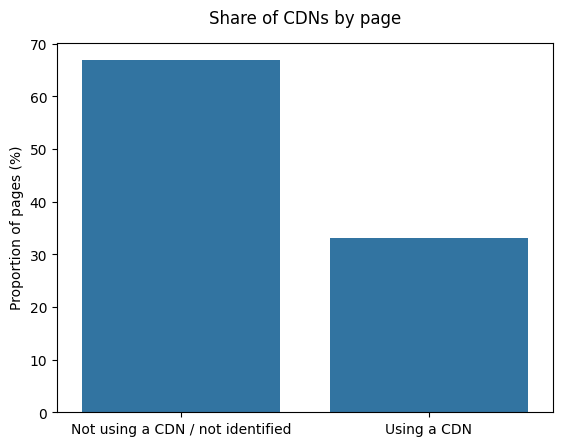

In [11]:
# Aggregation of the data
page_status = df.groupby('Page')['identified_via'].apply(lambda x: 'Not using a CDN / not identified' if 'Not a CDN / not identified' in x.values else 'Using a CDN').reset_index()

# Counting the categories
count_status = page_status['identified_via'].value_counts(normalize=True).reset_index()
count_status.columns = ['Category', 'Proportion']
count_status['Proportion'] = count_status['Proportion'] * 100

# Create bar chart
sns.barplot(x='Category', y='Proportion', data=count_status)
plt.ylabel('Proportion of pages (%)')
plt.xlabel('')
plt.title('Share of CDNs by page', y=1.03)
plt.show()

## Share of CDNs by request
Comparison of the proportion of requests answered by CDNs and requests not answered by CDNs or not identifiable as CDNs.

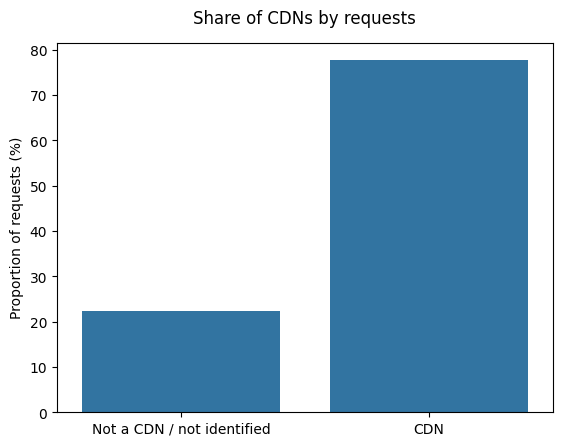

In [12]:
# Count the occurrences of the value "Not a CDN / not identified"
not_identified_count = (df['identified_via'] == 'Not a CDN / not identified').sum()

# Count the occurrences of all other values
identified_count = df.shape[0] - not_identified_count

# Calculate the percentages
total_count = df.shape[0]
not_identified_percentage = (not_identified_count / total_count) * 100
identified_percentage = (identified_count / total_count) * 100

# Create bar chart
categories = ['Not a CDN / not identified', 'CDN']
percentages = [not_identified_percentage, identified_percentage]

sns.barplot(x=categories, y=percentages)
plt.ylabel('Proportion of requests (%)')
plt.xlabel('')
plt.title('Share of CDNs by requests', y=1.03)
plt.show()

Share of requests served by a CDN:

In [13]:
identified_percentage

np.float64(77.67941342889476)

## Share of CDNs, differentiated by the way of identification

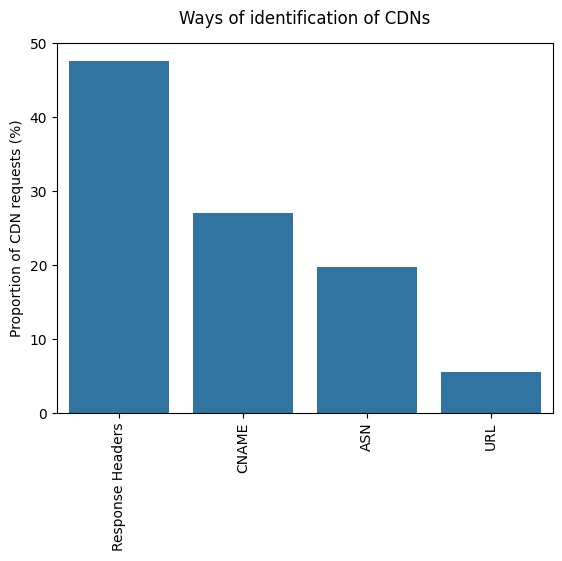

In [14]:
# Filter out not identified/non-CDNs
filtered_df = df[df['identified_via'] != 'Not a CDN / not identified']

# Count the occurrences of the individual values in the "identified_via" column
detected_by_counts = filtered_df['identified_via'].value_counts()

# Calculate the percentages
detected_by_percentages = detected_by_counts / detected_by_counts.sum() * 100

# Create bar chart
plt.xticks(rotation=90)
sns.barplot(x=detected_by_percentages.index, y=detected_by_percentages.values)
plt.ylabel('Proportion of CDN requests (%)')
plt.xlabel('')
plt.title("Ways of identification of CDNs", y=1.03)
plt.show()

# Share of CDN providers

Calculate the share/percentage of the detected CDN providers

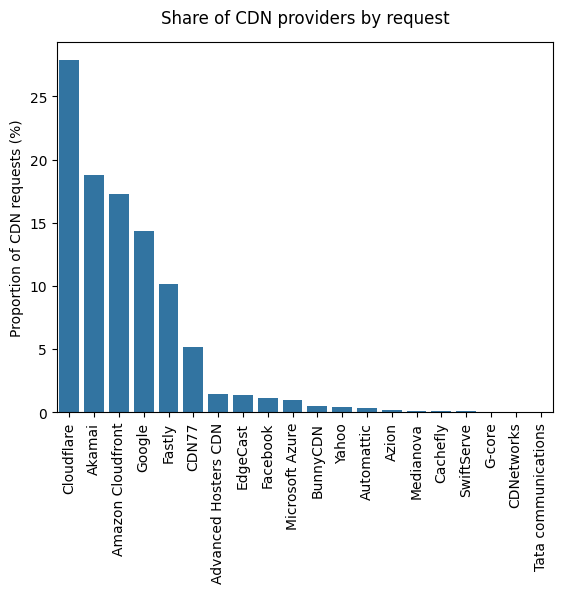

In [15]:
# Count the occurrences of the individual values in the "CDN" column
cdn_counts = df['CDN'].value_counts()

# Calculate the percentages
cdn_percentages = cdn_counts / cdn_counts.sum() * 100

# Create bar chart
plt.xticks(rotation=90)
sns.barplot(x=cdn_percentages.index, y=cdn_percentages.values)
plt.ylabel('Proportion of CDN requests (%)')
plt.xlabel('')
plt.title('Share of CDN providers by request', y=1.03)
plt.show()

## Expressed in number of requests
Showing the same data but with the actual numbers of requests instead of percentage.

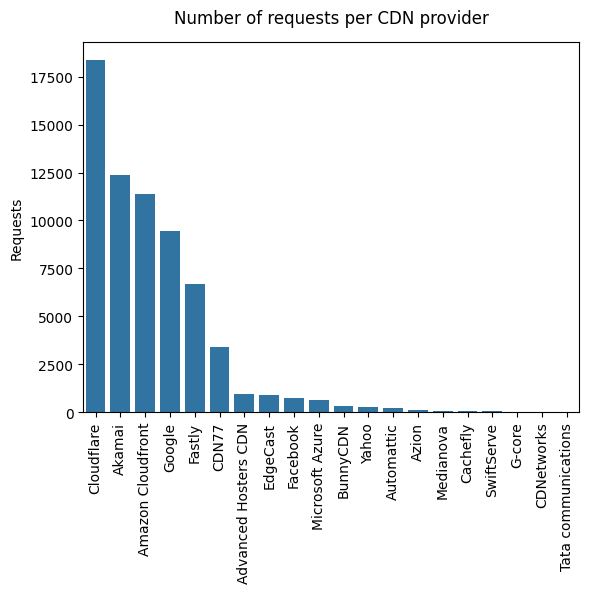

In [16]:
# Create bar chart
plt.xticks(rotation=90)
sns.barplot(data=cdn_counts)
plt.ylabel('Requests')
plt.xlabel('')
plt.title('Number of requests per CDN provider', y=1.03)
plt.show()

# Average number of requests

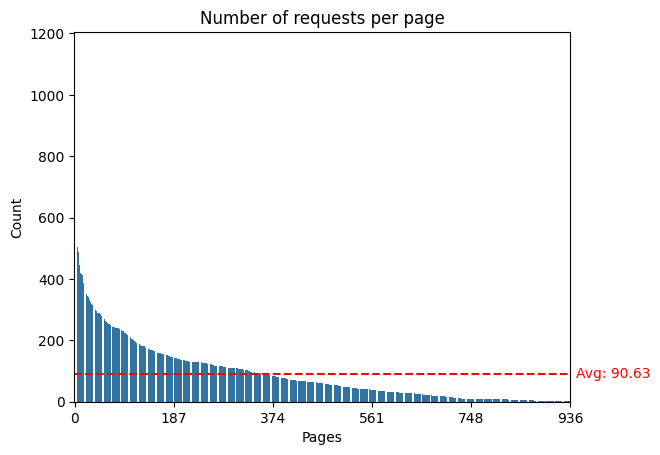

In [17]:
# Group by "Page" and count the number of occurrences
page_counts = df['Page'].value_counts().reset_index()
page_counts.columns = ['Page', 'Count']

# Sort by number of occurrences
page_counts = page_counts.sort_values(by='Count', ascending=False)

# Calculate average value
average_count = page_counts['Count'].mean()

# Create bar chart
sns.barplot(x=range(len(page_counts)), y=page_counts['Count'])
plt.xlabel('Pages')
plt.ylabel('Count')
plt.title('Number of requests per page')

# Add horizontal line for the average value
plt.axhline(average_count, color='red', linestyle='--')
plt.text(len(page_counts) + 10, average_count, f'Avg: {average_count:.2f}', color='red', va='center')

# Add custom ticks for the amount of pages
num_ticks = 5
total_pages = len(page_counts)
ticks = [i * (total_pages // num_ticks) for i in range(num_ticks + 1)]
tick_labels = [str(i * (total_pages // num_ticks)) for i in range(num_ticks)] + [str(total_pages)]
plt.xticks(ticks, tick_labels)

# Show plot
plt.show()

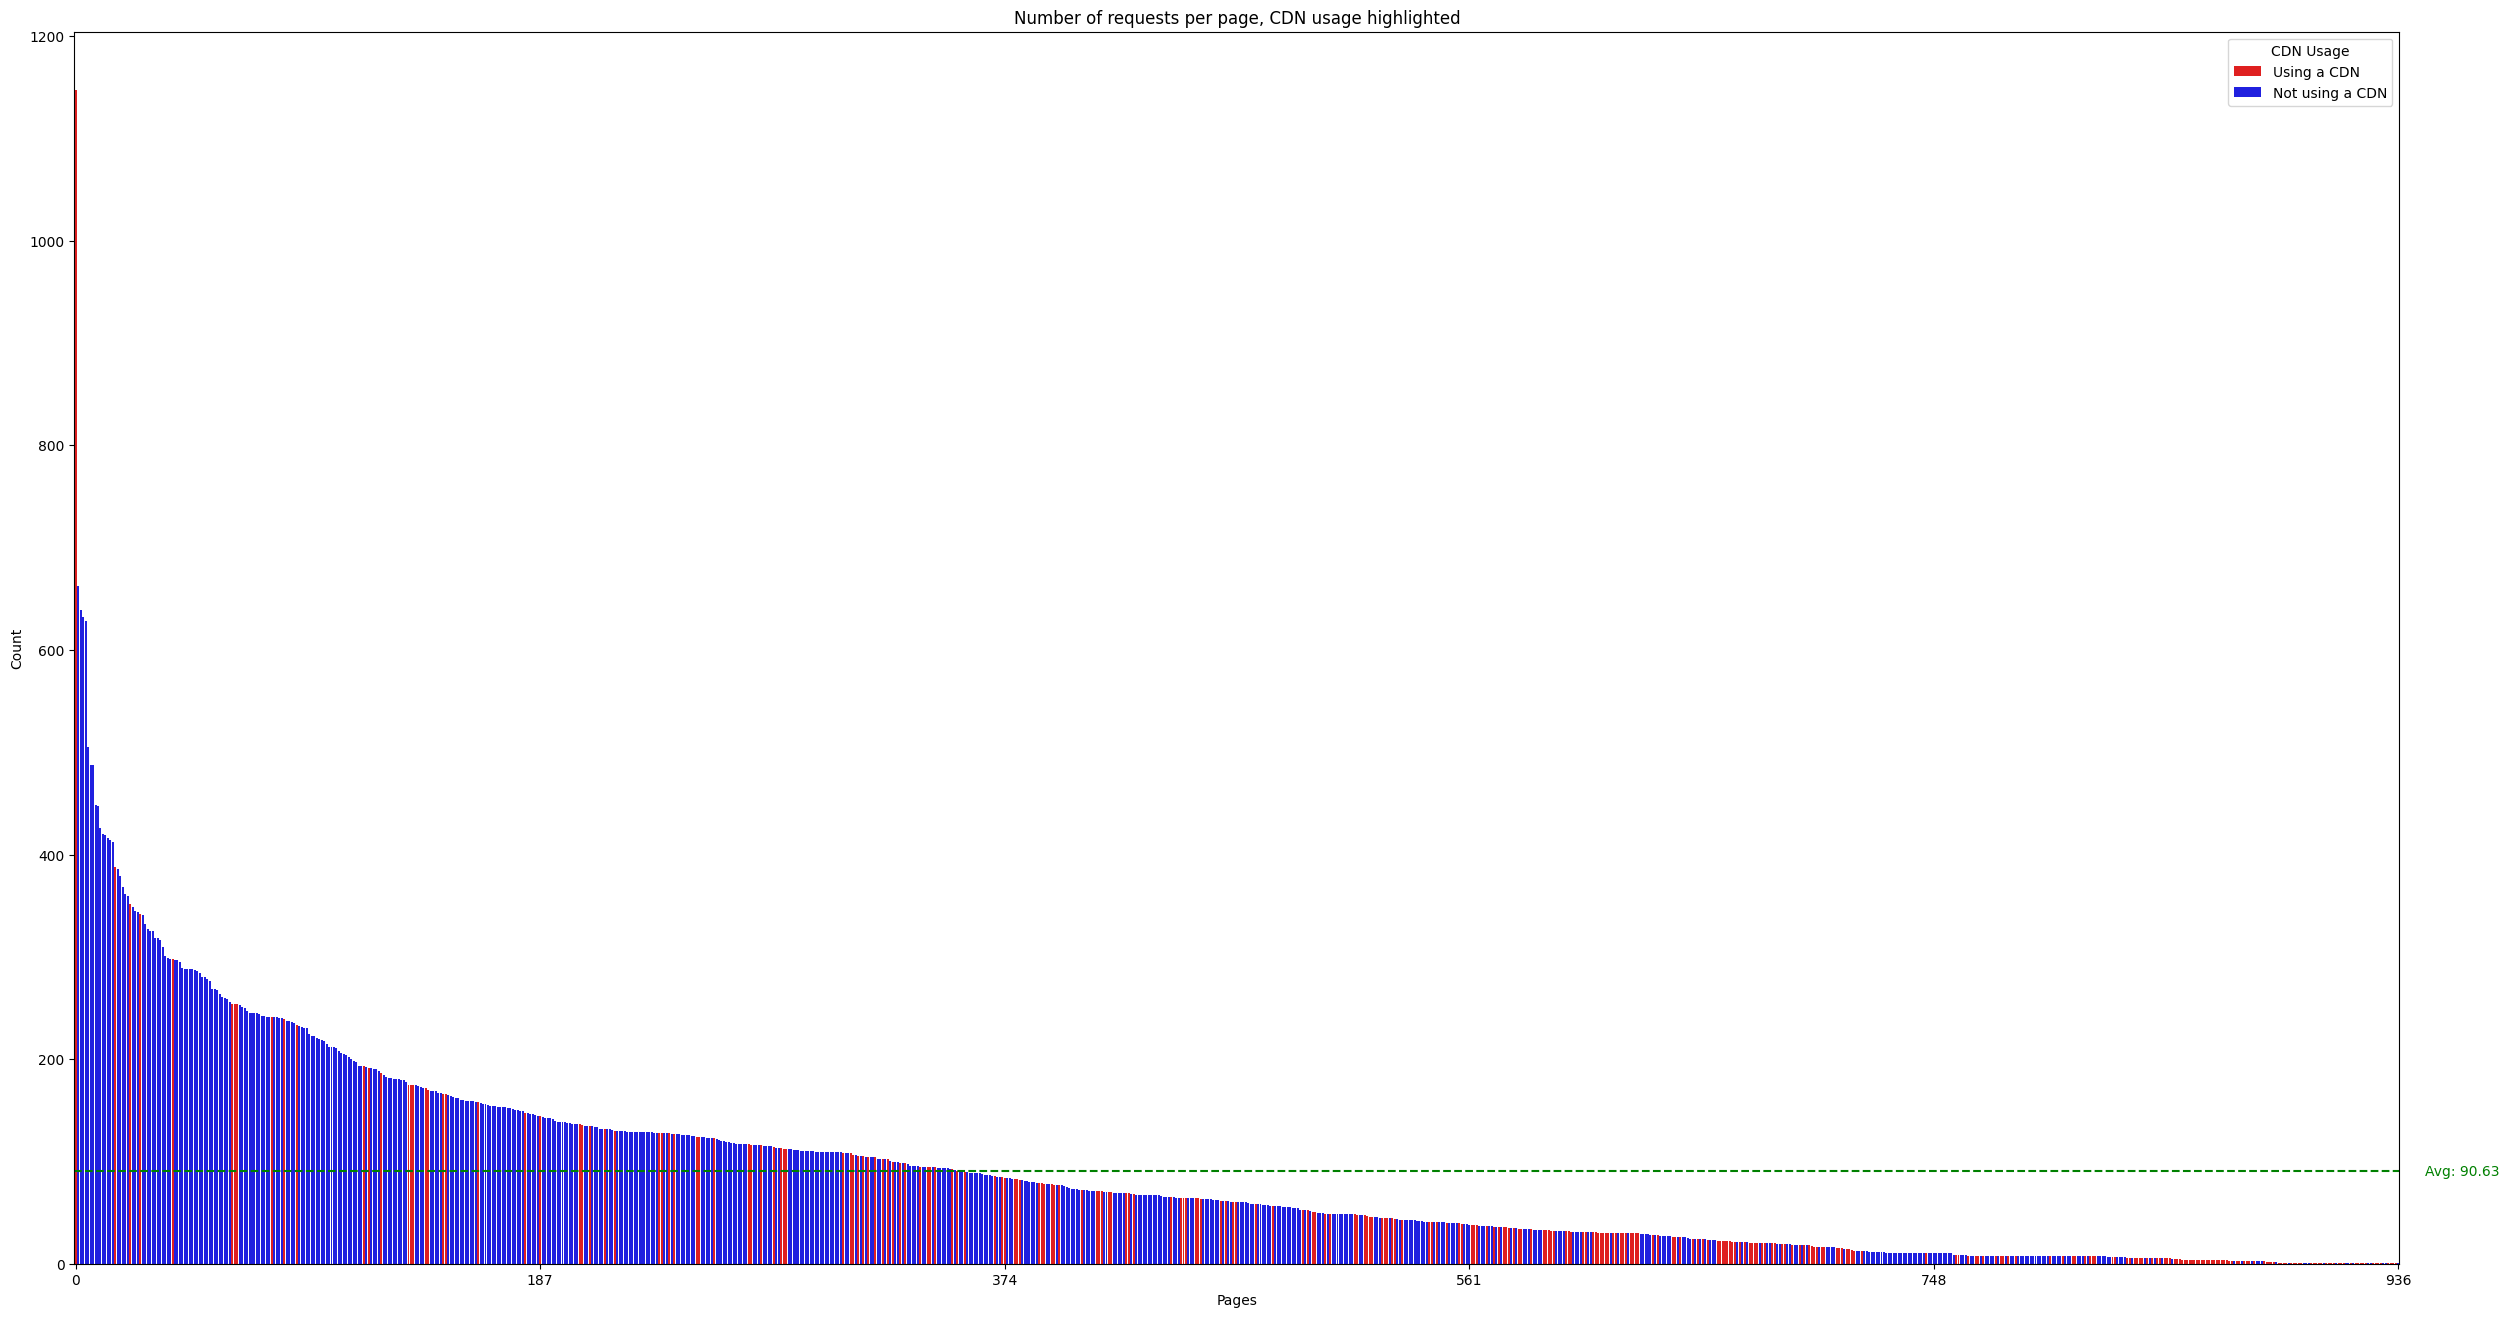

In [18]:

# Group by "Page" and count the number of occurrences
page_counts = df['Page'].value_counts().reset_index()
page_counts.columns = ['Page', 'Count']

# Merge with page_status DataFrame
merged_df = pd.merge(page_counts, page_status, on='Page', how='left')

# Sort by number of occurrences
merged_df = merged_df.sort_values(by='Count', ascending=False)

# Calculate average value
average_count = merged_df['Count'].mean()

# Create bar chart
plt.figure(figsize=(30, 16))

# Add a column for color classification (using a CDN or not)
merged_df['CDN_Usage'] = merged_df['identified_via'].apply(lambda x: 'Using a CDN' if x == 'Using a CDN' else 'Not using a CDN')

# Plot with hue based on CDN usage
sns.barplot(x=range(len(merged_df)), y=merged_df['Count'], hue=merged_df['CDN_Usage'], dodge=False, palette={'Using a CDN': 'red', 'Not using a CDN': 'blue'})
plt.xlabel('Pages')
plt.ylabel('Count')
plt.title('Number of requests per page, CDN usage highlighted')
plt.legend(title='CDN Usage')

# Add horizontal line for the average value
plt.axhline(average_count, color='green', linestyle='--')
plt.text(len(merged_df) + 10, average_count, f'Avg: {average_count:.2f}', color='green', va='center')

# Add custom ticks for the amount of pages
num_ticks = 5
total_pages = len(merged_df)
ticks = [i * (total_pages // num_ticks) for i in range(num_ticks + 1)]
tick_labels = [str(i * (total_pages // num_ticks)) for i in range(num_ticks)] + [str(total_pages)]
plt.xticks(ticks, tick_labels)

# Show plot
plt.show()


In [19]:
page_counts

,Page,Count
0,https://fast.com,1147
1,https://sports.sportingbet.com,663
2,https://www.idnes.cz,639
3,https://bbs.animanch.com,632
4,https://www.flashscore.com,628
...,...,...
931,https://www.imdb.com,1
932,https://www.naukri.com,1
933,https://wl1.peachavocado.com,1
934,https://www.casinoplus.com.ph,1


# Share of resource types

## Top resource types delivered by CDNs

These following common file types should be allowed for identification:

In [20]:
allowed_resources_to_identify = [".png", ".jpg", ".jpeg", "webp", ".avif", ".svg", ".gif", ".html", ".js", ".json", ".css", ".woff2", ".woff", ".ttf", ".otf", ".mp3", ".mp4", ".php"]

Identifying the resources:

In [21]:
def add_resource_type(row):
    """
    Applies the resource type to the "Resource Type" column of the given row 
    that was extracted from the url suffix
    """
    if not row["CDN"]:
        return
    suffix = pathlib.Path(str(row["Full URL"])).suffix
    if suffix:
        resource_type = find_substring_in_array(suffix, allowed_resources_to_identify)
        row["Resource Type"] = resource_type
        return pd.Series(row)
    return

In [22]:
def find_substring_in_array(string, array):
    """
    Checks whether any element of the array is a substring of the string and return the match
    """
    for substring in array:
        if substring in string.lower():
            return substring
    return

In [23]:
# Filter out non-CDN requests
filtered_cdns_df = df[df['CDN'].notna()]

# Apply the identification
filtered_cdns_df = filtered_cdns_df.apply(add_resource_type, axis=1)

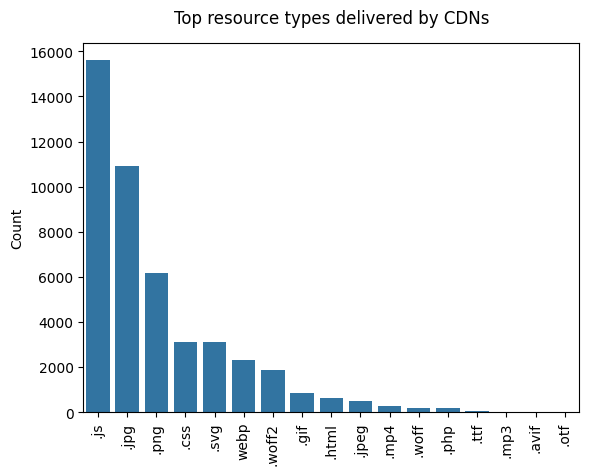

In [24]:
# Calculate frequencies of resource types
data_series = filtered_cdns_df["Resource Type"]
resource_type_frequencies = data_series.value_counts()

# Create bar chart
plt.xticks(rotation=90)
sns.barplot(data=resource_type_frequencies)
plt.title('Top resource types delivered by CDNs', y=1.03)
plt.ylabel('Count')
plt.xlabel('')
plt.show()

## Top resource types delivered by the individual CDNs

Only the top 10 identified resource types are used in the chart for clarity.

In [25]:
resources_for_stacked_chart = resource_type_frequencies.index.values[:10]

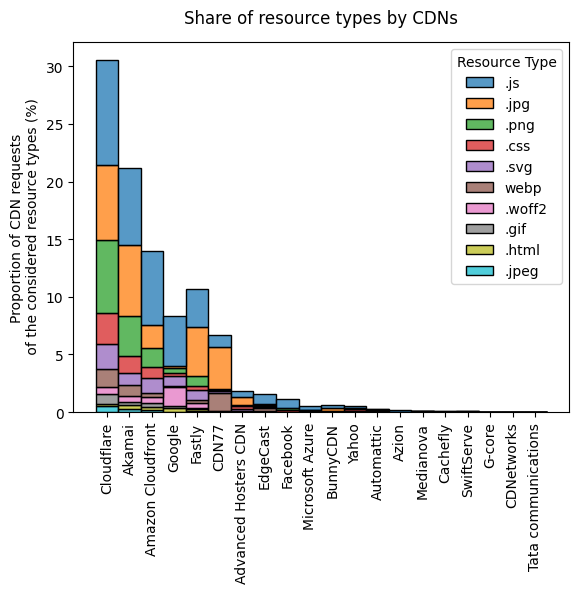

In [26]:
# Sorting data beforehand so the sns.histplot() function can be used to display a stacked bar plot

# Calculate the frequency of the values in the 'CDN' column
cdns_frequency = filtered_cdns_df['CDN'].value_counts()

# Sort the values by frequency
sorted_cdns = cdns_frequency.index

# Set the order of the values in the 'CDN' column
filtered_cdns_df['CDN'] = pd.Categorical(filtered_cdns_df['CDN'], categories=sorted_cdns, ordered=True)

# Create bar plot
plt.xticks(rotation=90)
sns.histplot(data=filtered_cdns_df, x="CDN", hue="Resource Type", multiple="stack", hue_order=resources_for_stacked_chart, stat='percent')
plt.xlabel('')
plt.ylabel('Proportion of CDN requests\n of the considered resource types (%)')
plt.title('Share of resource types by CDNs', y=1.03)
plt.show()

To get a better idea of how the shares of the different resources are distributed in the CDNs with lower values, create the same chart but with normalized values. Note, however, that the information value decreases with lower values. 

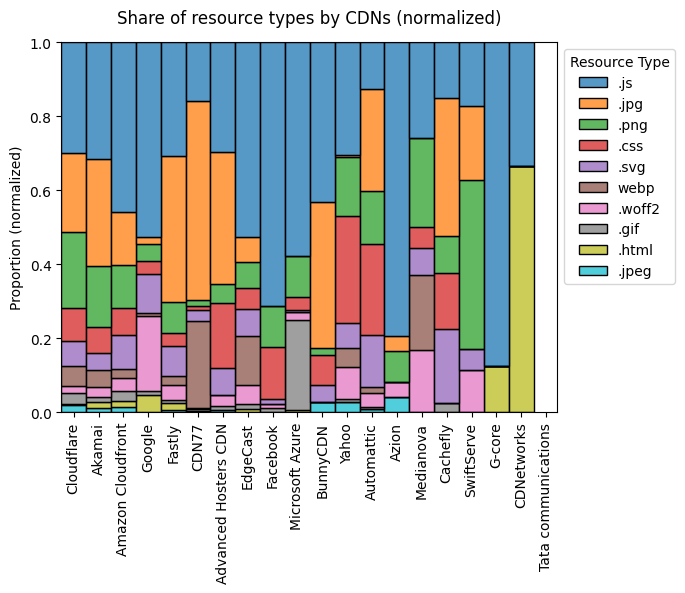

In [27]:
# Create bar plot
plt.xticks(rotation=90)
ax = sns.histplot(data=filtered_cdns_df, x="CDN", hue="Resource Type", multiple="fill", hue_order=resource_type_frequencies.index.values[:10], stat='proportion')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Proportion (normalized)')
plt.xlabel('')
plt.title('Share of resource types by CDNs (normalized)', y=1.03)
plt.show()

## Top resource types delivered by the individual CDNs (Top 6)

The same two diagrams but taken only the CDNs into account that have a share > 5 %

In [28]:
top_cdn_filter_array = filtered_cdns_df['CDN'].value_counts()[:6].index.values
top_cdn_filter_array

['Cloudflare', 'Akamai', 'Amazon Cloudfront', 'Google', 'Fastly', 'CDN77']
Categories (20, object): ['Cloudflare' < 'Akamai' < 'Amazon Cloudfront' < 'Google' ... 'SwiftServe' < 'G-core' < 'CDNetworks' < 'Tata communications']

In [29]:
top_cdn_filtered_df = filtered_cdns_df[filtered_cdns_df['CDN'].isin(top_cdn_filter_array)].reset_index()

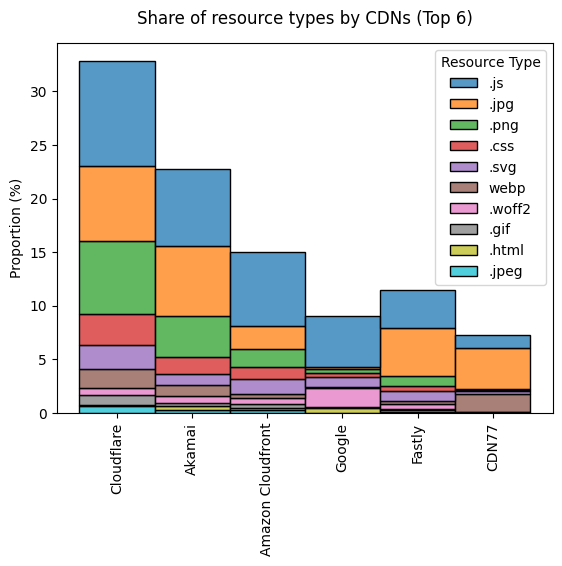

In [30]:
# Sorting data beforehand so the sns.histplot() function can be used to display a stacked bar plot

# Calculate the frequency of the values in the 'CDN' column
cdns_frequency = top_cdn_filtered_df['CDN'].value_counts()

# Sort the values by frequency
sorted_cdns = cdns_frequency.index

# Set the order of the values in the 'CDN' column
top_cdn_filtered_df['CDN'] = pd.Categorical(top_cdn_filtered_df['CDN'], categories=sorted_cdns, ordered=True)

# Create bar plot
plt.xticks(rotation=90)
sns.histplot(data=top_cdn_filtered_df, x="CDN", hue="Resource Type", multiple="stack", hue_order=resources_for_stacked_chart, stat='percent')
plt.xlabel('')
plt.ylabel('Proportion (%)')
plt.title('Share of resource types by CDNs (Top 6)', y=1.03)
plt.show()

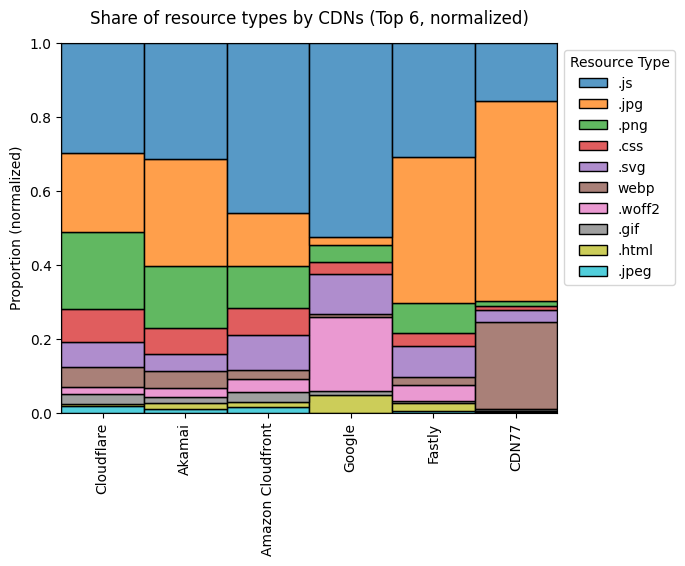

In [31]:
# Create bar plot
plt.xticks(rotation=90)
ax = sns.histplot(data=top_cdn_filtered_df, x="CDN", hue="Resource Type", multiple="fill", hue_order=resource_type_frequencies.index.values[:10], stat='proportion')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Proportion (normalized)')
plt.xlabel('')
plt.title('Share of resource types by CDNs (Top 6, normalized)', y=1.03)
plt.show()

# Shared CDN resources

## Shared CDN resources by exact URL


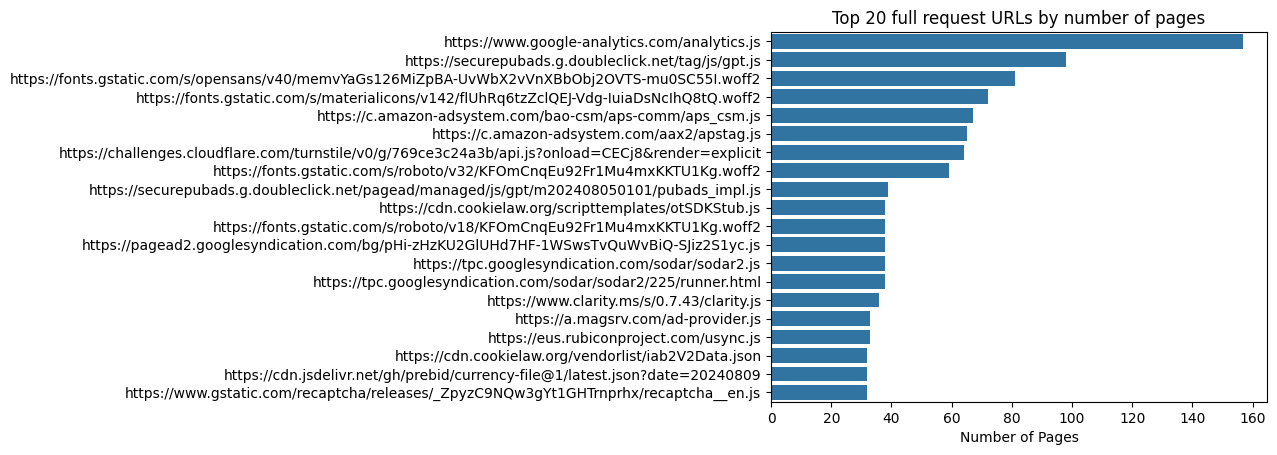

In [32]:
# Remove duplicates within each page
df_unique = filtered_cdns_df.drop_duplicates(subset=['Page', 'Full URL'])

# Count how often each full URL appears in different pages
url_counts = df_unique.groupby('Full URL').size().reset_index(name='Page Count')

# The top 20 URLs by number of pages in which they appear
top_urls = url_counts.nlargest(20, 'Page Count')

# Create bar chart
sns.barplot(x='Page Count', y='Full URL', data=top_urls)
plt.title('Top 20 full request URLs by number of pages')
plt.xlabel('Number of Pages')
plt.ylabel('')
plt.show()

In [33]:
top_urls.values

array([['https://www.google-analytics.com/analytics.js', 157],
       ['https://securepubads.g.doubleclick.net/tag/js/gpt.js', 98],
       ['https://fonts.gstatic.com/s/opensans/v40/memvYaGs126MiZpBA-UvWbX2vVnXBbObj2OVTS-mu0SC55I.woff2',
        81],
       ['https://fonts.gstatic.com/s/materialicons/v142/flUhRq6tzZclQEJ-Vdg-IuiaDsNcIhQ8tQ.woff2',
        72],
       ['https://c.amazon-adsystem.com/bao-csm/aps-comm/aps_csm.js', 67],
       ['https://c.amazon-adsystem.com/aax2/apstag.js', 65],
       ['https://challenges.cloudflare.com/turnstile/v0/g/769ce3c24a3b/api.js?onload=CECj8&render=explicit',
        64],
       ['https://fonts.gstatic.com/s/roboto/v32/KFOmCnqEu92Fr1Mu4mxKKTU1Kg.woff2',
        59],
       ['https://securepubads.g.doubleclick.net/pagead/managed/js/gpt/m202408050101/pubads_impl.js',
        39],
       ['https://cdn.cookielaw.org/scripttemplates/otSDKStub.js', 38],
       ['https://fonts.gstatic.com/s/roboto/v18/KFOmCnqEu92Fr1Mu4mxKKTU1Kg.woff2',
        38],
   

## Shared CDN resources by name

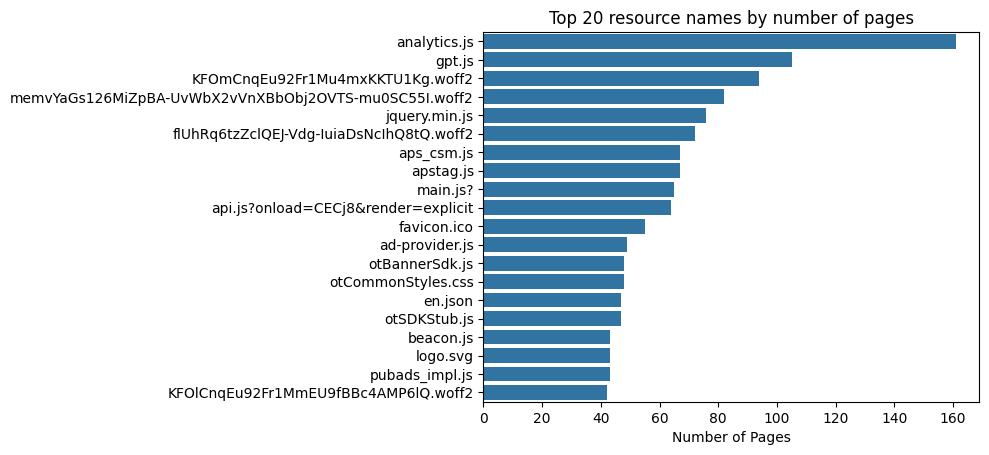

In [34]:
# Extract filename from Full URL
filtered_cdns_df['Resource Name'] = filtered_cdns_df['Full URL'].str.split('/').str[-1]

# Remove empty resource names
resource_names_df = filtered_cdns_df[filtered_cdns_df['Resource Name'] != '']

# Remove duplicates within each page
df_unique = resource_names_df.drop_duplicates(subset=['Page', 'Resource Name'])

# Count how often each resource name appears across different pages
resource_counts = df_unique.groupby('Resource Name').size().reset_index(name='Page Count')

# Get the top 20 resource names by the number of pages they appear on
top_resources = resource_counts.nlargest(20, 'Page Count')

# Create bar chart
sns.barplot(x='Page Count', y='Resource Name', data=top_resources)
plt.title('Top 20 resource names by number of pages')
plt.xlabel('Number of Pages')
plt.ylabel('')
plt.show()

In [35]:
top_resources.values

array([['analytics.js', 161],
       ['gpt.js', 105],
       ['KFOmCnqEu92Fr1Mu4mxKKTU1Kg.woff2', 94],
       ['memvYaGs126MiZpBA-UvWbX2vVnXBbObj2OVTS-mu0SC55I.woff2', 82],
       ['jquery.min.js', 76],
       ['flUhRq6tzZclQEJ-Vdg-IuiaDsNcIhQ8tQ.woff2', 72],
       ['aps_csm.js', 67],
       ['apstag.js', 67],
       ['main.js?', 65],
       ['api.js?onload=CECj8&render=explicit', 64],
       ['favicon.ico', 55],
       ['ad-provider.js', 49],
       ['otBannerSdk.js', 48],
       ['otCommonStyles.css', 48],
       ['en.json', 47],
       ['otSDKStub.js', 47],
       ['beacon.js', 43],
       ['logo.svg', 43],
       ['pubads_impl.js', 43],
       ['KFOlCnqEu92Fr1MmEU9fBBc4AMP6lQ.woff2', 42]], dtype=object)

# CDN popularity by delivered bytes

Saving the content length from the header in a separate collumn

In [36]:
# Function for extracting the 'content-length'
def extract_content_length(header_str):
    try:
        headers = ast.literal_eval(header_str)
        return headers.get('content-length')
    except (ValueError, SyntaxError):
        return

# Create new 'Content Length' column
df['Content Length'] = df['Response Headers'].apply(extract_content_length)

Type collumn "Content Length" numeric:

In [37]:
df['Content Length'] = pd.to_numeric(df['Content Length'])

Number of rows with a "Content Length":

In [38]:
df['Content Length'].count()

np.int64(57376)

Sum of all data (bytes) according to response headers:

In [39]:
df['Content Length'].sum()

np.float64(1628992805.0)

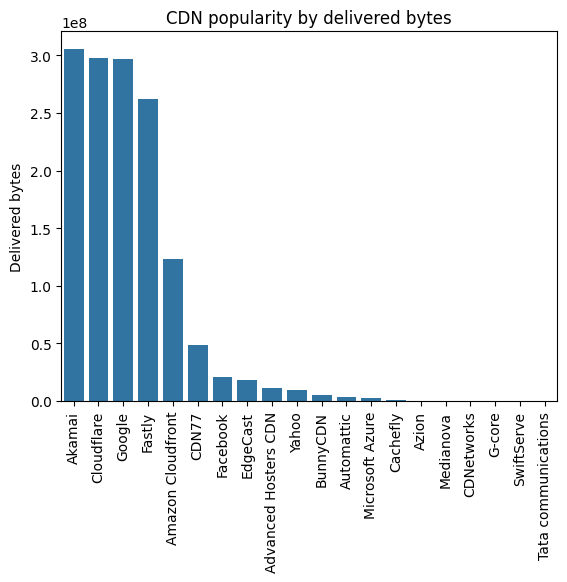

In [40]:
# Aggregate data
aggregated_df = df.groupby('CDN')['Content Length'].sum().reset_index()
aggregated_df = aggregated_df.sort_values(by="Content Length", ascending=False)

# Create bar chart
sns.barplot(x='CDN', y='Content Length', data=aggregated_df)
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Delivered bytes')
plt.title('CDN popularity by delivered bytes')
plt.show()

In [41]:
aggregated_df

,CDN,Content Length
1,Akamai,305417638.0
9,Cloudflare,297539436.0
14,Google,296425271.0
12,Fastly,262406464.0
2,Amazon Cloudfront,123410437.0
6,CDN77,48378666.0
11,Facebook,20655423.0
10,EdgeCast,18555062.0
0,Advanced Hosters CDN,11211954.0
19,Yahoo,9225795.0


To get an idea of the effect of the two popularity metrics used so far (number of requests, delivered bytes), here is the graph we just created, but with both the delivered bytes and the number of requests. In addition, the data is normalized to allow for a comparison of shares that would not be possible with absolute values alone.

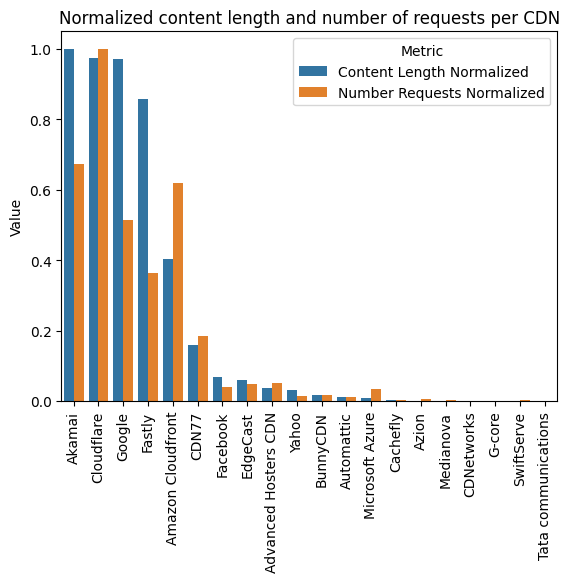

In [42]:
# Add new "Number Requests" column
aggregated_df['Number Requests'] = aggregated_df['CDN'].map(cdn_counts)

# Normalize the values
aggregated_df['Content Length Normalized'] = aggregated_df['Content Length'] / aggregated_df['Content Length'].max()
aggregated_df['Number Requests Normalized'] = aggregated_df['Number Requests'] / aggregated_df['Number Requests'].max()

# Convert data to long format for Seaborn
df_melted = aggregated_df.melt(id_vars='CDN', value_vars=['Content Length Normalized', 'Number Requests Normalized'], var_name='Metric', value_name='Value')

# Create bar chart
sns.barplot(x='CDN', y='Value', hue='Metric', data=df_melted)
plt.xlabel('')
plt.title('Normalized content length and number of requests per CDN')
plt.xticks(rotation=90)
plt.show()

In [43]:
aggregated_df

,CDN,Content Length,Number Requests,Content Length Normalized,Number Requests Normalized
1,Akamai,305417638.0,12386,1.000000,0.674068
9,Cloudflare,297539436.0,18375,0.974205,1.000000
14,Google,296425271.0,9438,0.970557,0.513633
12,Fastly,262406464.0,6681,0.859173,0.363592
2,Amazon Cloudfront,123410437.0,11388,0.404071,0.619755
6,CDN77,48378666.0,3407,0.158402,0.185415
11,Facebook,20655423.0,749,0.067630,0.040762
10,EdgeCast,18555062.0,871,0.060753,0.047401
0,Advanced Hosters CDN,11211954.0,949,0.036710,0.051646
19,Yahoo,9225795.0,264,0.030207,0.014367
